In [70]:
import scanpy as sc
import numpy as np
import statsmodels.api as sm
import pandas as pd

In [71]:
adata = sc.read_h5ad('dataset.h5ad')

In [72]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [73]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [74]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]

In [75]:
sc.pp.pca(adata, n_comps=50)

C:\Users\hp\anaconda3\envs\scRNAseq_env\lib\site-packages\scanpy\preprocessing\_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


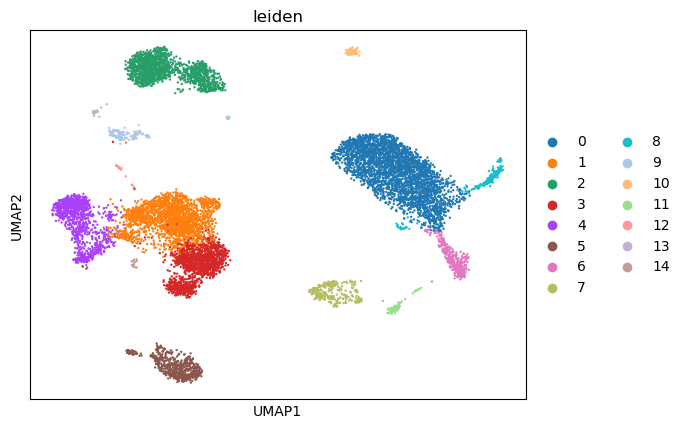

In [76]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.leiden(adata, resolution=0.5)
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_pca") 
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'])
output = pd.DataFrame({
    'Id': range(len(adata.obs['leiden'])),
    'Label': adata.obs['leiden'].astype(int) + 1
})
output.to_csv('task1.1_clustering_results.csv', index=False)
task1_labels = adata.obs['leiden']

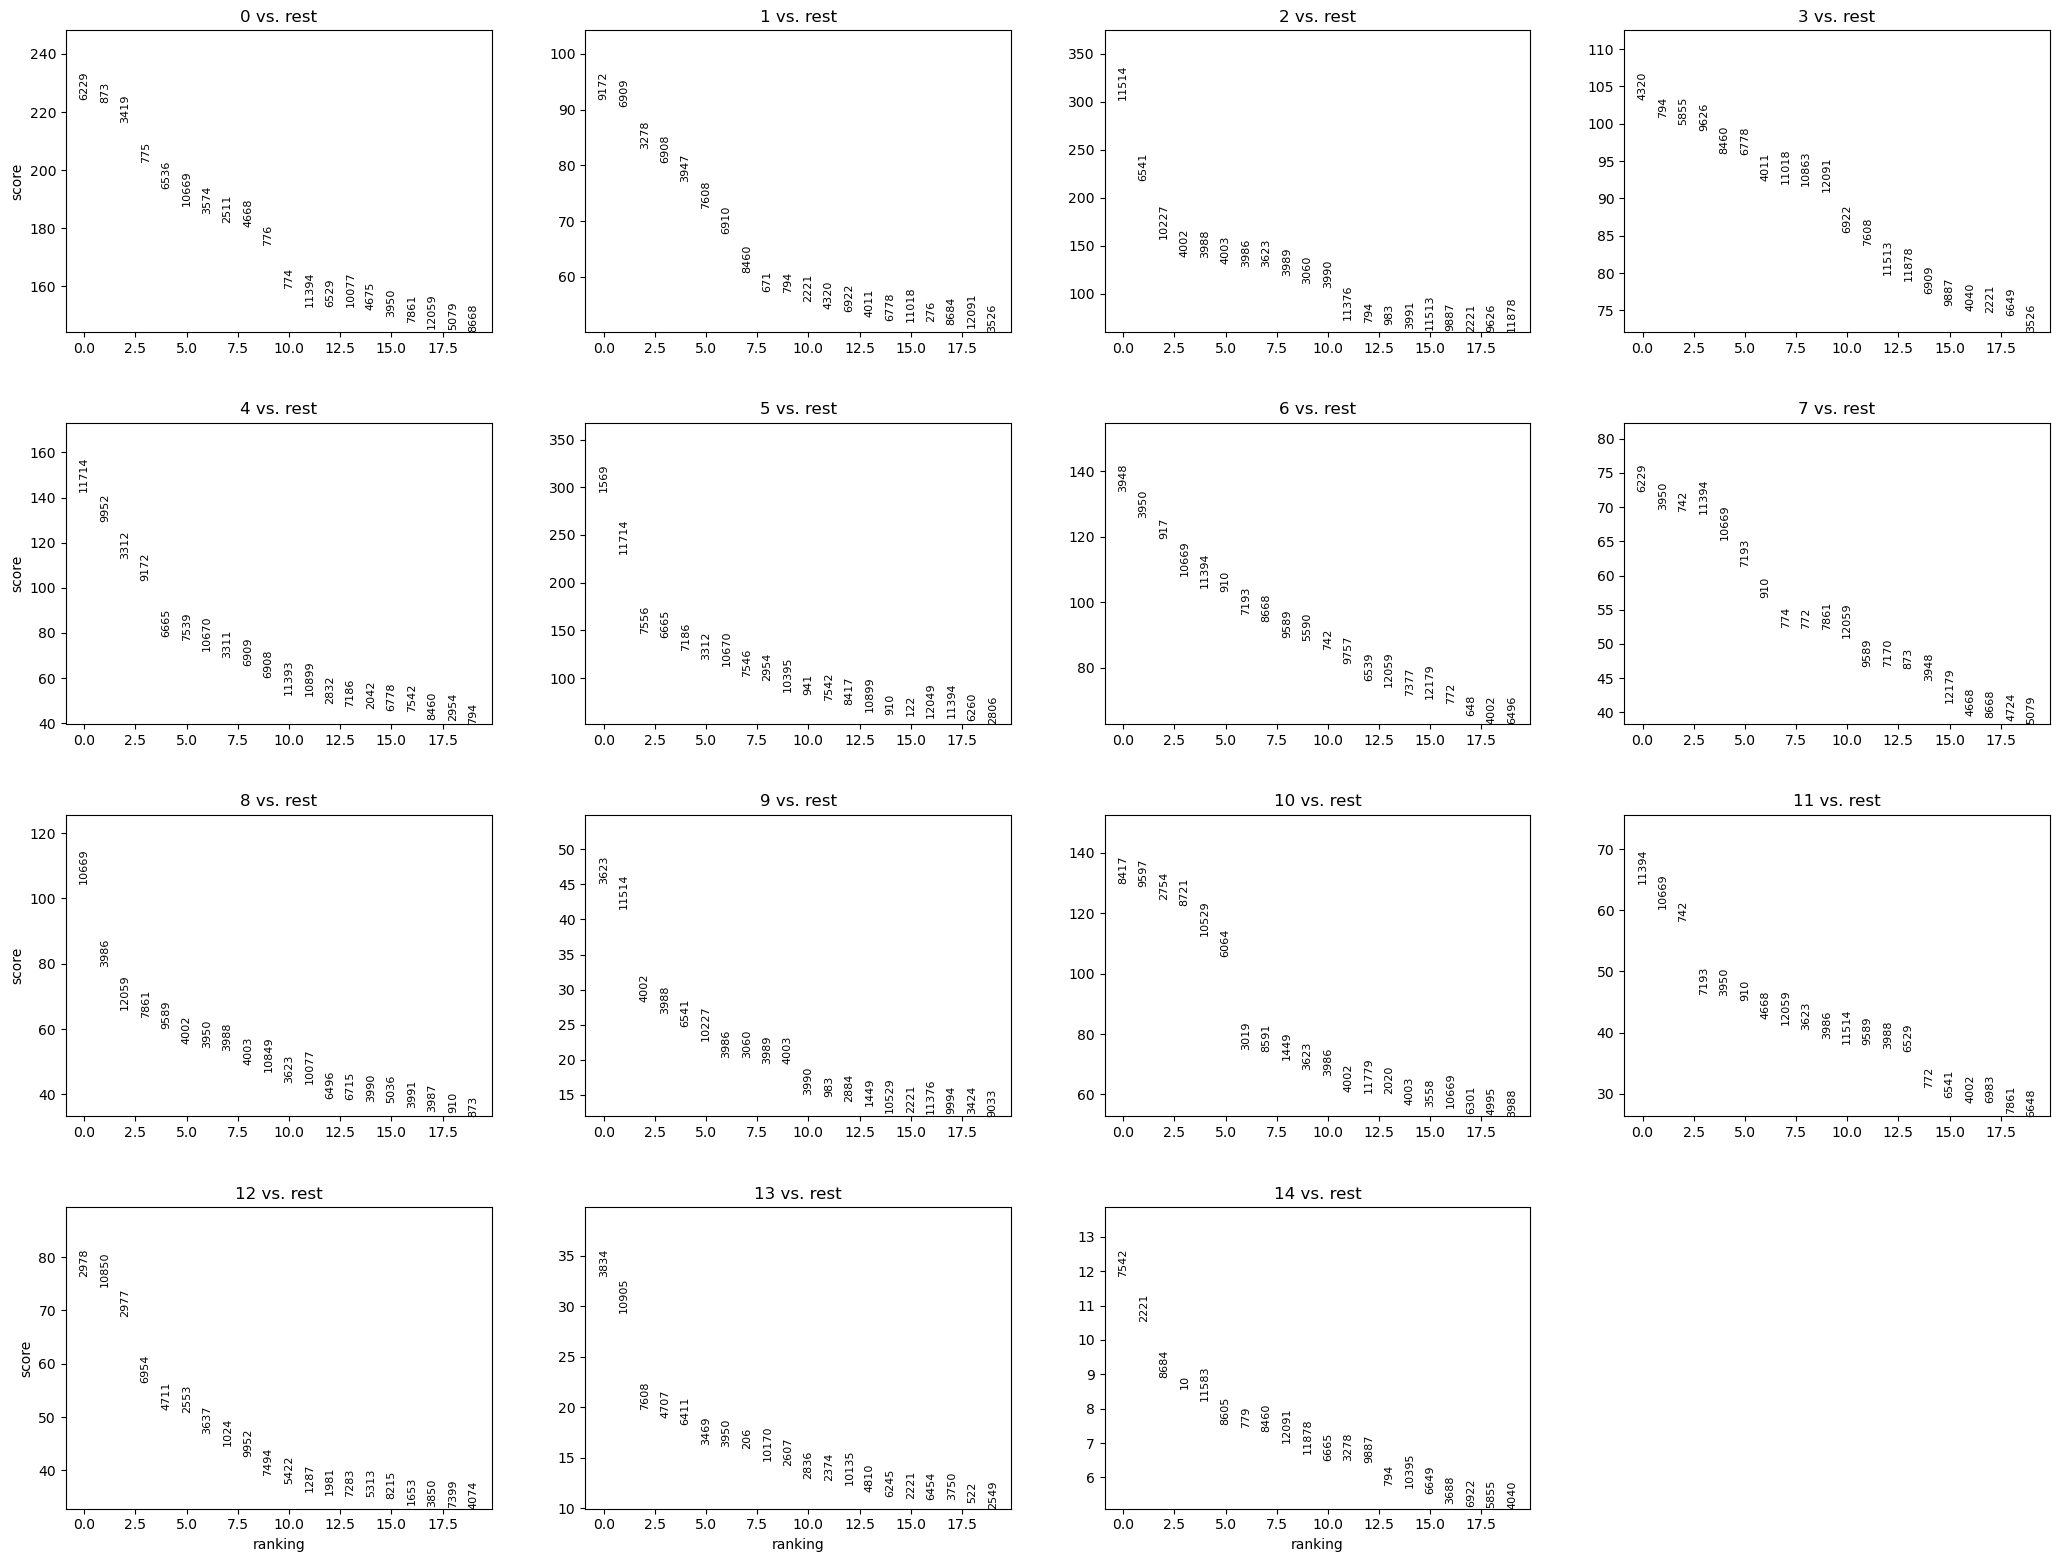

In [77]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [78]:
adata = sc.read_h5ad('dataset.h5ad')

In [79]:
X = adata.X.A if hasattr(adata.X, 'A') else adata.X

In [80]:
def compute_deviance_residuals(X):
    deviance_scores = []
    for gene_idx in range(X.shape[1]):
        y = X[:, gene_idx]
        if np.all(y == 0):
            deviance_scores.append(0)
            continue
        try:
            model = sm.GLM(y, np.ones_like(y), family=sm.families.Poisson())
            results = model.fit()
            deviance = results.deviance
        except Exception as e:
            deviance = np.nan
        deviance_scores.append(deviance)
    return np.array(deviance_scores)

In [81]:
deviance_scores = compute_deviance_residuals(X)

top_genes_indices = np.argsort(-deviance_scores)[:2000]
adata = adata[:, top_genes_indices]

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
output = pd.DataFrame({
    'Id': range(len(adata.obs['leiden'])),
    'Label': adata.obs['leiden'].astype(int) + 1
})
output.to_csv('task1.2_clustering_results.csv', index=False)

C:\Users\hp\anaconda3\envs\scRNAseq_env\lib\site-packages\scanpy\preprocessing\_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


In [82]:
adata.obs['leiden_task1'] = task1_labels
adata.obs['leiden_new'] = adata.obs['leiden']  

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

labels_task1 = adata.obs['leiden_task1'].astype(int)
labels_new = adata.obs['leiden_new'].astype(int)

# Adjusted Rand Index (ARI) - Measures the similarity between two clusterings
ari_score = adjusted_rand_score(labels_task1, labels_new)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# Normalized Mutual Information (NMI) - Measures the information shared between two clusterings
nmi_score = normalized_mutual_info_score(labels_task1, labels_new)
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

Adjusted Rand Index (ARI): 0.7129
Normalized Mutual Information (NMI): 0.8455
